So in This Experience I've Applied Data augmentation on the class of  upstairs and downstaires with the class weightning technique on the  Sitting and standing

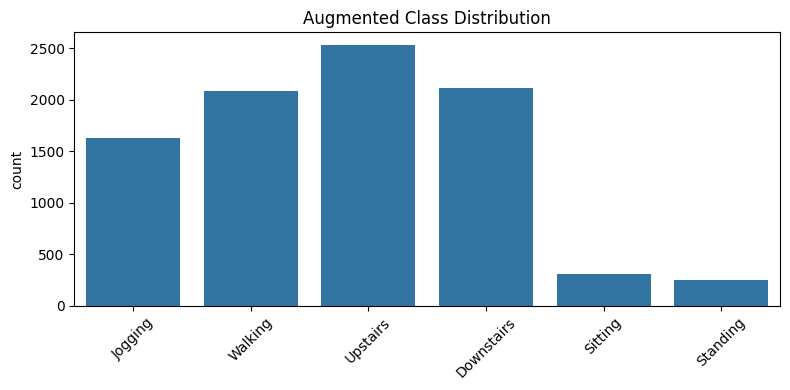

In [7]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv1D, LSTM, Dense, Dropout, BatchNormalization, Add
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import seaborn as sns

# Optional: simple jittering function for augmentation
def add_jitter(X, sigma=0.01):
    noise = np.random.normal(loc=0, scale=sigma, size=X.shape)
    return X + noise

# Load the dataset
data = pd.read_csv(r"C:\Users\MSI\Desktop\Mitacs Project\Human Activity Recognition\HAR-WISDM\Data_WISDM\WISDM_cleaned.csv")

# Separate features and target
X = data.drop('class', axis=1)
y = data['class']

# Encode class labels
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Reshape data for CNN-LSTM: assuming 30 features = (10 time steps × 3 features)
X_reshaped = X_scaled.reshape(-1, 10, 3)
y_reshaped = y_encoded.reshape(-1)

# === Data Augmentation on Downstairs and Upstairs ===
def augment_minority_classes(X, y, classes_to_augment, augment_func, augment_factor=2):
    X_augmented = []
    y_augmented = []
    
    for cls in classes_to_augment:
        X_cls = X[y == cls]
        for _ in range(augment_factor):
            X_augmented.append(augment_func(X_cls))
            y_augmented.append(np.full(len(X_cls), cls))
    
    X_aug = np.concatenate(X_augmented, axis=0)
    y_aug = np.concatenate(y_augmented, axis=0)
    
    # Append augmented data to original
    X_new = np.concatenate([X, X_aug], axis=0)
    y_new = np.concatenate([y, y_aug], axis=0)
    
    return X_new, y_new

# Identify classes to augment by label index
classes_to_augment = []
for class_name in ['Downstairs', 'Upstairs']:
    cls_idx = label_encoder.transform([class_name])[0]
    classes_to_augment.append(cls_idx)

# Apply augmentation with jittering (augment_factor can be changed)
X_augmented, y_augmented = augment_minority_classes(X_reshaped, y_reshaped, classes_to_augment, add_jitter, augment_factor=3)

# Compute class weights on augmented data
class_weights_aug = compute_class_weight('balanced', classes=np.unique(y_augmented), y=y_augmented)
class_weight_dict_aug = dict(enumerate(class_weights_aug))

# Visualize augmented class distribution
plt.figure(figsize=(8, 4))
sns.countplot(x=label_encoder.inverse_transform(y_augmented))
plt.title('Augmented Class Distribution')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Now use X_augmented, y_augmented and class_weight_dict_aug for your training pipeline


In [9]:
# === REPLACE your old training script with this one ===

# Build CNN-LSTM with residual connections
def build_cnn_lstm_model(input_shape, num_classes):
    inputs = Input(shape=input_shape)
    
    # CNN Block 1
    x = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(inputs)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # Residual Connection
    conv1 = Conv1D(64, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    conv1 = BatchNormalization()(conv1)
    x = Add()([x, conv1])
    x = Dropout(0.2)(x)
    
    # CNN Block 2
    x = Conv1D(128, kernel_size=5, padding='same', activation='relu', kernel_regularizer=l2(0.01))(x)
    x = BatchNormalization()(x)
    x = Dropout(0.2)(x)
    
    # LSTM Layer
    x = LSTM(128, return_sequences=False, kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    
    # Dense Layers
    x = Dense(128, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.2)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Initialize stratified K-Fold
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold = 1
f1_scores = []

for train_idx, val_idx in skf.split(X_augmented, y_augmented):
    print(f"\n📚 Training Fold {fold}")
    X_train, X_val = X_augmented[train_idx], X_augmented[val_idx]
    y_train, y_val = y_augmented[train_idx], y_augmented[val_idx]
    
    # Optional: light data augmentation on training data (e.g., jittering)
    # X_train = add_jitter(X_train, sigma=0.02)

    model = build_cnn_lstm_model(input_shape=(10, 3), num_classes=len(np.unique(y_augmented)))
    
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
    
    history = model.fit(
        X_train, y_train,
        epochs=150,
        batch_size=64,
        class_weight=class_weight_dict_aug,
        validation_data=(X_val, y_val),
        callbacks=[early_stopping, reduce_lr],
        verbose=1
    )
    
    # Evaluate model
    y_pred = model.predict(X_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    
    print(f"\n🧾 Fold {fold} Classification Report:")
    print(classification_report(y_val, y_pred_classes, target_names=label_encoder.classes_))
    
    # Store macro F1-score
    report = classification_report(y_val, y_pred_classes, output_dict=True)
    f1_scores.append(report['macro avg']['f1-score'])
    fold += 1

# Final macro F1 score across folds
print(f"\n✅ Average Macro F1-Score across {skf.n_splits} folds: {np.mean(f1_scores):.4f} ± {np.std(f1_scores):.4f}")



📚 Training Fold 1
Epoch 1/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 7s 21ms/step - accuracy: 0.2783 - loss: 5.2272 - val_accuracy: 0.2820 - val_loss: 3.1252 - learning_rate: 0.0010
Epoch 2/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.3801 - loss: 2.4978 - val_accuracy: 0.3629 - val_loss: 2.1260 - learning_rate: 0.0010
Epoch 3/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4190 - loss: 1.7274 - val_accuracy: 0.4242 - val_loss: 1.7051 - learning_rate: 0.0010
Epoch 4/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.4276 - loss: 1.4675 - val_accuracy: 0.4635 - val_loss: 1.5248 - learning_rate: 0.0010
Epoch 5/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4258 - loss: 1.3434 - val_accuracy: 0.4573 - val_loss: 1.4123 - learning_rate: 0.0010
Epoch 6/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.4232 - loss: 1.2757 - val_accuracy: 0.4708 - val_loss: 1.4050 - learning_rate: 0.0010
Epoch 7/150
112/112 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - a